In [1]:
import h5py
import pylab as pl
import numpy as np
import scipy.stats as sp
import matplotlib as mpl
import networkx
import progressbar
import astropy.cosmology as apc

In [2]:
def split_unique_id(unique_id):
    """Splits the ids assign to the subhalos by the merger tree code by snap number and subfind number """
    subfind_number = int(unique_id % 1e6)
    snap_number = int((unique_id - subfind_number) / 1e6)
    
    return snap_number, subfind_number

def get_main_branch_unique_ids(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    i = 0
    while True:
        succesors = list(subtree.successors(node))
        if len(succesors) == 0:
            break
        node = succesors[0] # select only the first succesor (main branch)
        mpb.append(node)
        
    return mpb

In [3]:
pl.rc('font', size = 20)
pl.rc('legend', fontsize = 20)
sim = h5py.File('/data/cielo/simulations/LG1/LG1.hdf5', 'r')
trees = networkx.read_multiline_adjlist('/data/cielo/simulations/LG1/LG1_tree.dat')

In [4]:
Slist = h5py.File('SatelliteList_V2_withAngles_n500.h5', 'r')
Satellites = Slist['SatelliteList'][()]
Centrals = Slist['SatelliteCentral'][()]
CosCen = Slist['CosCen'][()]
CosVel = Slist['CosVel'][()]
#LzL = Slist['LZ_L'][()]
Satellites.size

19

In [5]:
#ok, now the serialized version of the get particles for each Satellite, lets see.
TdayTotalIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][()] # need this first
I= np.identity(3) # and this

In [6]:
def getAllLastP(fofID, centralID):
    """
    get position, masses and abundances of all particles that in past snapshot belong to a given subhalo,
    and a z=0 are located at athe maximum distance of 600 kpc to the subhalo,
    rotated by the velocity and the vector to the centre.
    """
    uniqueID = int(128*1e6+fofID)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    #firts find all the particleIDs that once belong to the subgroup
    Idlist = []

    for mm in mtree[1:]: # ignore the first one
        snap, idd = split_unique_id(int(mm))
        tempOff = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
        if tempOff[0]>= 0 and tempOff[1]>=0:
            tempIds = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][tempOff[0]:tempOff[1]]
            Idlist.extend(list(tempIds))

    Idlist = np.array(Idlist)
    Idlist = np.unique(Idlist) # remove duplicates
    
    TdayOff = sim['SnapNumber_128/SubGroups/PartType0/Offsets'][fofID].astype('int')
    
    IndexToday = np.in1d(TdayTotalIDs, Idlist)
    IndexToday_ = np.where(IndexToday)[0]
    
    # lets remove the ones that are not part of the group today.
    TdayIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][TdayOff[0]:TdayOff[1]]

    IndexNot = np.in1d(Idlist, TdayIDs)
    IdNot = Idlist[np.where(IndexNot==False)[0]]

    IndexT = np.in1d(TdayTotalIDs, IdNot)
    IndexT_ = np.where(IndexT)[0]
    
    #now lets cut at  a certain distance
    #distance = 600 # distance in ckpc
    distance = 200 
    
    posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][fofID]
    posCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][centralID]

    LostCoord = sim['SnapNumber_128/PartType0/Coordinates'][IndexT_]
    
    dx, dy, dz = LostCoord[:,0]-posGal[0], LostCoord[:,1]-posGal[1], LostCoord[:,2]-posGal[2]
    distToC = np.sqrt(dx**2+dy**2+dz**2)

    icut = np.where(distToC<distance)[0]
    IndexT_near = IndexT_[icut] # this is the final list of particles ids
    
    # ok, lest see velocity and stuff
    velCen = sim['SnapNumber_128/SubGroups/SubGroupVel'][centralID]
    velSat = sim['SnapNumber_128/SubGroups/SubGroupVel'][fofID]

    velRep = velSat - velCen
    
    GasMasses = sim['SnapNumber_128/PartType0/Masses'][IndexT_near]
    GassAbundances = sim['SnapNumber_128/PartType0/Abundances'][IndexT_near]
    
    NearCoord = sim['SnapNumber_128/PartType0/Coordinates'][IndexT_near]

    # first lets re-define coordinates in a galactocentric scheme.
    X, Y, Z = NearCoord[:,0] - posGal[0], NearCoord[:,1] - posGal[1], NearCoord[:,2] - posGal[2]
    xC, yC, zC = posCen[0] - posGal[0], posCen[1] - posGal[1], posCen[2] - posGal[2] # the direction of the centre from the galaxy
    
    # now define normalized vectors, for velocity and centre directions
    velX, velY, velZ = velRep[0], velRep[1], velRep[2]
    Vel = np.sqrt(velX**2 + velY**2 + velZ**2)
    Cen = np.sqrt(xC**2 + yC**2 + zC**2)

    velx, vely, velz = velX/Vel, velY/Vel, velZ/Vel
    xc, yc, zc = xC/Cen, yC/Cen, zC/Cen
    
    # Then, the rotations matrix are, for velocity
    faV = (1-velx)/(vely**2 + velz**2)
    VV = np.array([[0, vely, velz], [-vely, 0, 0], [-velz, 0, 0]])
    VV2 = np.matmul(VV, VV)

    RV = I + VV + VV2*faV
    
    # and for the direction to the centre
    faC = (1-xc)/(yc**2+zc**2)
    CC = np.array([[0, yc, zc], [-yc, 0, 0], [-zc, 0, 0]])
    CC2 = np.matmul(CC, CC)

    RC = I + CC + CC2*faC
    
    # lets calculate the rotated coordinates
    xRv, yRv, zRv = [], [], []
    xRc, yRc, zRc = [], [], []

    for x, y, z in zip(X, Y, Z):
        dV = np.matmul(RV, np.array([x, y, z]))
        dC = np.matmul(RC, np.array([x, y, z]))
    
        xRv.append(dV[0])
        yRv.append(dV[1])
        zRv.append(dV[2])
    
        xRc.append(dC[0])
        yRc.append(dC[1])
        zRc.append(dC[2])
    
    xRv, yRv, zRv = np.array(xRv), np.array(yRv), np.array(zRv)
    xRc, yRc, zRc = np.array(xRc), np.array(yRc), np.array(zRc)
    
    # now, I only need one number, the cos stuff
    cosC = xRc/np.sqrt(xRc**2.+yRc**2.+zRc**2.)
    cosV = xRv/np.sqrt(xRv**2.+yRv**2.+zRv**2.)
    
    # and return the 2 sets of rotated positions, masses and abundances
    return cosV, cosC, GasMasses, GassAbundances

Text(0.5, 0, 'r/r_200')

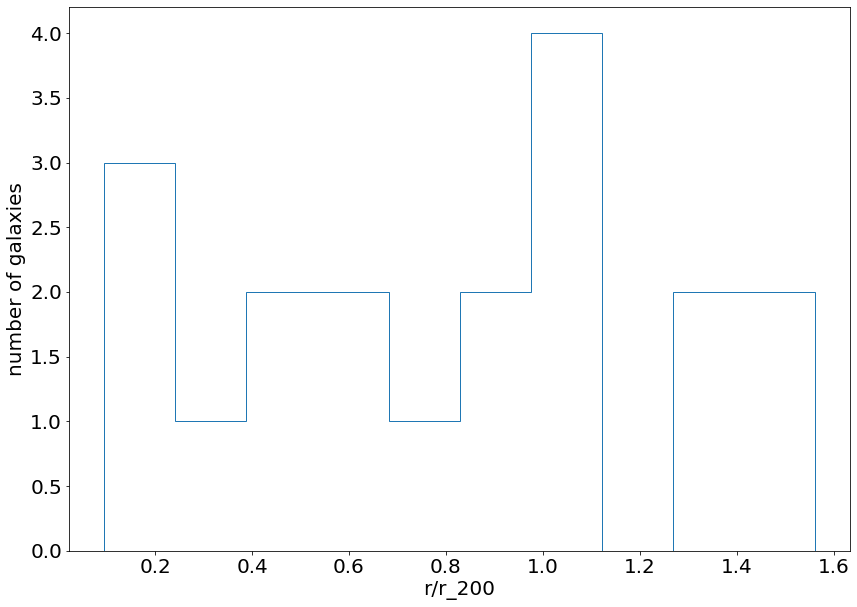

In [7]:
# lets test somo clean up by separation.
R200, GalCen, GroCen = [], [], []

for ss, cc in zip(Satellites, Centrals):
    group = sim['SnapNumber_128/SubGroups/GroupNumber'][cc]
    r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]
    galCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][ss]
    groCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][cc]
    
    R200.append(r200)
    GalCen.append(galCen)
    GroCen.append(groCen)

R200, GalCen, GroCen = np.array(R200), np.array(GalCen), np.array(GroCen)

sep = GalCen - GroCen
dist = np.sqrt(sep[:,0]**2+sep[:,1]**2+sep[:,2]**2)
dist = dist/R200

# Satellites = Slist['SatelliteList'][()]
# Centrals = Slist['SatelliteCentral'][()]
# CosCen = Slist['CosCen'][()]
# CosVel = Slist['CosVel'][()]
# LzL = Slist['LZ_L'][()]

pl.figure(figsize=(14, 10))

pl.hist(dist, histtype='step')
pl.ylabel('number of galaxies')
pl.xlabel('r/r_200')

In [8]:
ir = np.where(dist>0.5)

Satellites = Satellites[ir]
Centrals = Centrals[ir]
CosCen = CosCen[ir]
CosVel = CosVel[ir]
#LzL = LzL[ir]

Satellites.size, CosCen.min()

(14, -0.9617047452183579)

In [9]:
# lets separate by Cosines
CosCen = np.abs(CosCen)
CosVel = np.abs(CosVel)

medCen = np.median(CosCen)
medVel = np.median(CosVel)

errCen = np.std(CosCen)/np.sqrt(CosCen.size)
errVel = np.std(CosVel)/np.sqrt(CosVel.size)

print(medCen, medVel)
print(errCen, errVel)

i1Cen = np.where(CosCen<0.5)
i2Cen = np.where(CosCen>0.5)

i1Vel = np.where(CosVel<0.5)
i2Vel = np.where(CosVel>0.5)

satC1, centC1 = Satellites[i1Cen], Centrals[i1Cen]
satC2, centC2 = Satellites[i2Cen], Centrals[i2Cen]

satV1, centV1 = Satellites[i1Vel], Centrals[i1Vel]
satV2, centV2 = Satellites[i2Vel], Centrals[i2Vel]

0.7372144876682933 0.5844498953907924
0.08018401243914401 0.06475009282704786


In [10]:
# low cos central
size = satC1.size
# size = 100

bar = progressbar.ProgressBar(max_value=size)
C, passs = 0, 0

CosRv_C1, CosRc_C1, GASMasses_C1, GASAbundances_C1 = [], [], [], []
StarMass_C1 = []

for ff, cc in zip(satC1, centC1):
    try:
        cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
        passs += 1
    except:
        C += 1
        continue
    
    CosRv_C1.extend(list(cosRv))
    CosRc_C1.extend(list(cosRc))
    GASMasses_C1.extend(list(GasMasses))
    GASAbundances_C1.extend(list(GasAbundances))
    
    # and star masses
    offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
    STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
    STM = np.sum(STMass)
    
    StarMass_C1.extend([STM]*cosRv.size)
    
    C += 1
    bar.update(C)
    
CosRv_C1, CosRc_C1, GASMasses_C1, GASAbundances_C1 = np.array(CosRv_C1), np.array(CosRc_C1), np.array(GASMasses_C1), np.array(GASAbundances_C1)
StarMass_C1 = np.array(StarMass_C1)
passs

100% (6 of 6) |##########################| Elapsed Time: 0:00:20 ETA:  00:00:00

6

In [11]:
 # high cos central
size = satC2.size
# size = 100

bar = progressbar.ProgressBar(max_value=size)
C, passs = 0, 0

CosRv_C2, CosRc_C2, GASMasses_C2, GASAbundances_C2 = [], [], [], []
StarMass_C2 = []

for ff, cc in zip(satC2, centC2):
    try:
        cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
        passs += 1
    except:
        C += 1
        continue
    CosRv_C2.extend(list(cosRv))
    CosRc_C2.extend(list(cosRc))
    GASMasses_C2.extend(list(GasMasses))
    
    GASAbundances_C2.extend(list(GasAbundances))
    
     # and star masses
    offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
    STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
    STM = np.sum(STMass)
    StarMass_C2.extend([STM]*cosRv.size)
    
    C += 1
    bar.update(C)
    
CosRv_C2, CosRc_C2, GASMasses_C2, GASAbundances_C2 = np.array(CosRv_C2), np.array(CosRc_C2), np.array(GASMasses_C2), np.array(GASAbundances_C2)
StarMass_C2 = np.array(StarMass_C2)

passs

100% (8 of 8) |##########################| Elapsed Time: 0:01:35 ETA:  00:00:00

8

In [12]:
# low cos velocity
size = satV1.size
# size = 100

bar = progressbar.ProgressBar(max_value=size)
C, passs = 0, 0

CosRv_V1, CosRc_V1, GASMasses_V1, GASAbundances_V1 = [], [], [], []
StarMass_V1 = []

for ff, cc in zip(satV1, centV1):
    try:
        cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
        passs += 1
    except:
        C += 1
        continue
    CosRv_V1.extend(list(cosRv))
    CosRc_V1.extend(list(cosRc))
    GASMasses_V1.extend(list(GasMasses))
    
    GASAbundances_V1.extend(list(GasAbundances))
    
    # and star masses
    offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
    STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
    STM = np.sum(STMass)
    StarMass_V1.extend([STM]*cosRv.size)
    
    C += 1
    bar.update(C)
    
CosRv_V1, CosRc_V1, GASMasses_V1, GASAbundances_V1 = np.array(CosRv_V1), np.array(CosRc_V1), np.array(GASMasses_V1), np.array(GASAbundances_V1)
StarMass_V1 = np.array(StarMass_V1)

passs

100% (6 of 6) |##########################| Elapsed Time: 0:00:21 ETA:  00:00:00

6

In [13]:
# low cos velocity
size = satV2.size
# size = 100

bar = progressbar.ProgressBar(max_value=size)
C, passs = 0, 0

CosRv_V2, CosRc_V2, GASMasses_V2, GASAbundances_V2 = [], [], [], []
StarMass_V2 = []

for ff, cc in zip(satV2, centV2):
    try:
        cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
        passs += 1
    except:
        C += 1
        continue
    CosRv_V2.extend(list(cosRv))
    CosRc_V2.extend(list(cosRc))
    GASMasses_V2.extend(list(GasMasses))
    
    GASAbundances_V2.extend(list(GasAbundances))
    
    # and star masses
    offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
    STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
    STM = np.sum(STMass)
    StarMass_V2.extend([STM]*cosRv.size)
    
    C += 1
    bar.update(C)
    
CosRv_V2, CosRc_V2, GASMasses_V2, GASAbundances_V2 = np.array(CosRv_V2), np.array(CosRc_V2), np.array(GASMasses_V2), np.array(GASAbundances_V2)
StarMass_V2 = np.array(StarMass_V2)

passs

100% (8 of 8) |##########################| Elapsed Time: 0:02:55 ETA:  00:00:00

8

Text(0, 0.5, 'Gas Mass/Stellar Mass')

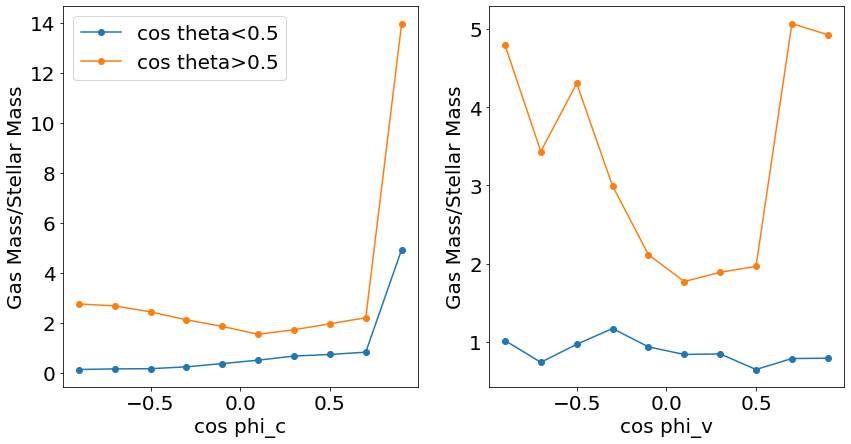

In [14]:
# cos C for both

pl.figure(figsize=(14, 7))

sumC1, binsC1, zipC1 = sp.binned_statistic(CosRc_C1, GASMasses_C1/StarMass_C1, statistic='sum', bins=10, range=(-1.,1.))
sumC2, binsC2, zipC2 = sp.binned_statistic(CosRc_C2, GASMasses_C2/StarMass_C2, statistic='sum', bins=10, range=(-1.,1.))

sumV1, binsV1, zipV1 = sp.binned_statistic(CosRv_C1, GASMasses_C1/StarMass_C1, statistic='sum', bins=10, range=(-1.,1.))
sumV2, binsV2, zipV2 = sp.binned_statistic(CosRv_C2, GASMasses_C2/StarMass_C2, statistic='sum', bins=10, range=(-1.,1.))

# bins should be the same
x_x = .5*(binsV2[:-1]+binsV2[1:])

pl.subplot(1, 2, 1)

pl.plot(x_x, sumC1, marker='o', label='cos theta<0.5')
pl.plot(x_x, sumC2, marker='o', label='cos theta>0.5')

pl.legend(loc='best')

pl.xlabel('cos phi_c')
pl.ylabel('Gas Mass/Stellar Mass')

pl.subplot(1, 2, 2)

pl.plot(x_x, sumV1, marker='o', label='cos theta<0.5')
pl.plot(x_x, sumV2, marker='o', label='cos theta>0.5')

pl.xlabel('cos phi_v')
pl.ylabel('Gas Mass/Stellar Mass')

Text(0, 0.5, 'Gas Mass/Stellar Mass')

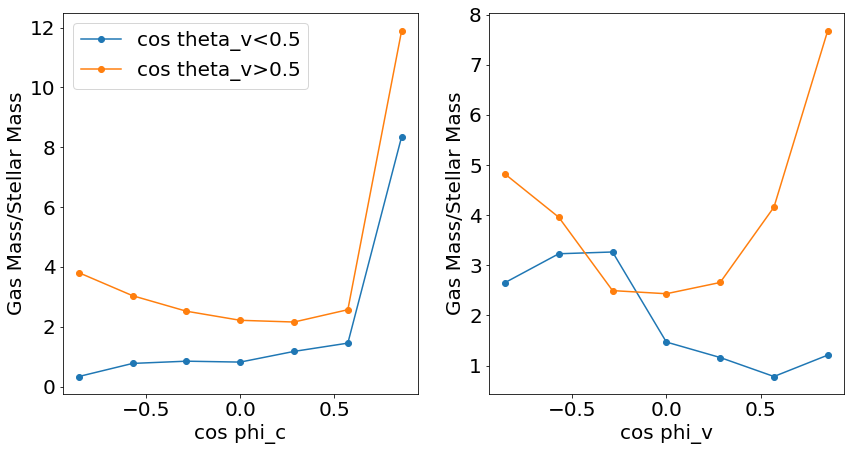

In [15]:
# cos V for both

pl.figure(figsize=(14, 7))

sumC1_V, binsC1_V, zipC1_V = sp.binned_statistic(CosRc_V1, GASMasses_V1/StarMass_V1, statistic='sum', bins=7, range=(-1.,1.))
sumC2_V, binsC2_V, zipC2_V = sp.binned_statistic(CosRc_V2, GASMasses_V2/StarMass_V2, statistic='sum', bins=7, range=(-1.,1.))

sumV1_V, binsV1_V, zipV1_V = sp.binned_statistic(CosRv_V1, GASMasses_V1/StarMass_V1, statistic='sum', bins=7, range=(-1.,1.))
sumV2_V, binsV2_V, zipV2_V = sp.binned_statistic(CosRv_V2, GASMasses_V2/StarMass_V2, statistic='sum', bins=7, range=(-1.,1.))

# bins should be the same
x_x = .5*(binsV2_V[:-1]+binsV2_V[1:])

pl.subplot(1, 2, 1)

pl.plot(x_x, sumC1_V, marker='o', label='cos theta_v<0.5')
pl.plot(x_x, sumC2_V, marker='o', label='cos theta_v>0.5')

pl.legend(loc='best')

pl.xlabel('cos phi_c')
pl.ylabel('Gas Mass/Stellar Mass')

pl.subplot(1, 2, 2)

pl.plot(x_x, sumV1_V, marker='o', label='cos theta<0.5')
pl.plot(x_x, sumV2_V, marker='o', label='cos theta>0.5')

pl.xlabel('cos phi_v')
pl.ylabel('Gas Mass/Stellar Mass')

In [16]:
# # lets separate galaxies between those that are moving toward the center and away the center.
# # dk if time is important, maybe separation 2 is between firts enter and backplashes.

# def sepPosC(ff, cc):
#     velGal = sim['SnapNumber_128/SubGroups/SubGroupVel'][ff]
#     velCen = sim['SnapNumber_128/SubGroups/SubGroupVel'][cc]
    
#     posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][ff]
#     posCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][cc]
    
#     velT = velCen - velGal
#     cendD = posCen - posGal
    
#     nVel = np.sqrt(velT[0]**2.+velT[1]**2.+velT[2]**2.)
#     ncenD = np.sqrt(cendD[0]**2.+cendD[1]**2.+cendD[2]**2.)
    
#     ndot = velT[0]*cendD[0] + velT[1]*cendD[1] + velT[2]*cendD[2]
#     cosB = ndot/(nVel*ncenD)
#     return cosB

In [17]:
# cosBC1 = []
# for ff, cc in zip(satC1, centC1):
#     cb = sepPosC(ff, cc)
#     cosBC1.append(cb)
    
# cosBC1 = np.array(cosBC1)

# cosBC2 = []
# for ff, cc in zip(satC2, centC2):
#     cb = sepPosC(ff, cc)
#     cosBC2.append(cb)
    
# cosBC2 = np.array(cosBC2)

# cosBV1 = []
# for ff, cc in zip(satV1, centV1):
#     cb = sepPosC(ff, cc)
#     cosBV1.append(cb)
    
# cosBV1 = np.array(cosBV1)

# cosBV2 = []
# for ff, cc in zip(satV2, centV2):
#     cb = sepPosC(ff, cc)
#     cosBV2.append(cb)
    
# cosBV2 = np.array(cosBV2)

In [18]:
# allCB = list(cosBC1)
# allCB.extend(list(cosBC2))
# allCB = np.array(allCB)

# pl.figure(figsize=(14,7))

# pl.hist(allCB, bins=2)

In [19]:
# iC1_1 = np.where(cosBC1<0.)
# iC1_2 = np.where(cosBC1>0.)

# iC2_1 = np.where(cosBC2<0.)
# iC2_2 = np.where(cosBC2>0.)

# iV1_1 = np.where(cosBV1<0.)
# iV1_2 = np.where(cosBV1>0.)

# iV2_1 = np.where(cosBV2<0.)
# iV2_2 = np.where(cosBV2>0.)

# satC1_1, centC1_1 = satC1[iC1_1], centC1[iC1_1]
# satC1_2, centC1_2 = satC1[iC1_2], centC1[iC1_2]

# satC2_1, centC2_1 = satC2[iC2_1], centC2[iC2_1]
# satC2_2, centC2_2 = satC2[iC2_2], centC2[iC2_2]

# satV1_1, centV1_1 = satV1[iV1_1], centV1[iV1_1]
# satV1_2, centV1_2 = satV1[iV1_2], centV1[iV1_2]

# satV2_1, centV2_1 = satV2[iV2_1], centV2[iV2_1]
# satV2_2, centV2_2 = satV2[iV2_2], centV2[iV2_2]

In [20]:
# # low cos central
# size = satC1_1.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_C1_1, CosRc_C1_1, GASMasses_C1_1, GASAbundances_C1_1 = [], [], [], []
# StarMass_C1_1 = []

# for ff, cc in zip(satC1_1, centC1_1):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
    
#     CosRv_C1_1.extend(list(cosRv))
#     CosRc_C1_1.extend(list(cosRc))
#     GASMasses_C1_1.extend(list(GasMasses))
#     GASAbundances_C1_1.extend(list(GasAbundances))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
    
#     StarMass_C1_1.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_C1_1, CosRc_C1_1, GASMasses_C1_1, GASAbundances_C1_1 = np.array(CosRv_C1_1), np.array(CosRc_C1_1), np.array(GASMasses_C1_1), np.array(GASAbundances_C1_1)
# StarMass_C1_1 = np.array(StarMass_C1_1)
# passs

In [21]:
# # low cos central
# size = satC1_2.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_C1_2, CosRc_C1_2, GASMasses_C1_2, GASAbundances_C1_2 = [], [], [], []
# StarMass_C1_2 = []

# for ff, cc in zip(satC1_2, centC1_2):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
    
#     CosRv_C1_2.extend(list(cosRv))
#     CosRc_C1_2.extend(list(cosRc))
#     GASMasses_C1_2.extend(list(GasMasses))
#     GASAbundances_C1_2.extend(list(GasAbundances))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
    
#     StarMass_C1_2.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_C1_2, CosRc_C1_2, GASMasses_C1_2, GASAbundances_C1_2 = np.array(CosRv_C1_2), np.array(CosRc_C1_2), np.array(GASMasses_C1_2), np.array(GASAbundances_C1_2)
# StarMass_C1_2 = np.array(StarMass_C1_2)
# passs

In [22]:
# # low cos central
# size = satC2_1.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_C2_1, CosRc_C2_1, GASMasses_C2_1, GASAbundances_C2_1 = [], [], [], []
# StarMass_C2_1 = []

# for ff, cc in zip(satC2_1, centC2_1):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
    
#     CosRv_C2_1.extend(list(cosRv))
#     CosRc_C2_1.extend(list(cosRc))
#     GASMasses_C2_1.extend(list(GasMasses))
#     GASAbundances_C2_1.extend(list(GasAbundances))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
    
#     StarMass_C2_1.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_C2_1, CosRc_C2_1, GASMasses_C2_1, GASAbundances_C2_1 = np.array(CosRv_C2_1), np.array(CosRc_C2_1), np.array(GASMasses_C2_1), np.array(GASAbundances_C2_1)
# StarMass_C2_1 = np.array(StarMass_C2_1)
# passs

In [23]:
# # low cos central
# size = satC2_2.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_C2_2, CosRc_C2_2, GASMasses_C2_2, GASAbundances_C2_2 = [], [], [], []
# StarMass_C2_2 = []

# for ff, cc in zip(satC2_2, centC2_2):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
    
#     CosRv_C2_2.extend(list(cosRv))
#     CosRc_C2_2.extend(list(cosRc))
#     GASMasses_C2_2.extend(list(GasMasses))
#     GASAbundances_C2_2.extend(list(GasAbundances))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
    
#     StarMass_C2_2.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_C2_2, CosRc_C2_2, GASMasses_C2_2, GASAbundances_C2_2 = np.array(CosRv_C2_2), np.array(CosRc_C2_2), np.array(GASMasses_C2_2), np.array(GASAbundances_C2_2)
# StarMass_C2_2 = np.array(StarMass_C2_2)
# passs

In [24]:
# # low cos central
# size = satV1_1.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_V1_1, CosRc_V1_1, GASMasses_V1_1, GASAbundances_V1_1 = [], [], [], []
# StarMass_V1_1 = []

# for ff, cc in zip(satV1_1, centV1_1):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
    
#     CosRv_V1_1.extend(list(cosRv))
#     CosRc_V1_1.extend(list(cosRc))
#     GASMasses_V1_1.extend(list(GasMasses))
#     GASAbundances_V1_1.extend(list(GasAbundances))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
    
#     StarMass_V1_1.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_V1_1, CosRc_V1_1, GASMasses_V1_1, GASAbundances_V1_1 = np.array(CosRv_V1_1), np.array(CosRc_V1_1), np.array(GASMasses_V1_1), np.array(GASAbundances_V1_1)
# StarMass_V1_1 = np.array(StarMass_V1_1)
# passs

In [25]:
# size = satV1_2.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_V1_2, CosRc_V1_2, GASMasses_V1_2, GASAbundances_V1_2 = [], [], [], []
# StarMass_V1_2 = []

# for ff, cc in zip(satV1_2, centV1_2):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
    
#     CosRv_V1_2.extend(list(cosRv))
#     CosRc_V1_2.extend(list(cosRc))
#     GASMasses_V1_2.extend(list(GasMasses))
#     GASAbundances_V1_2.extend(list(GasAbundances))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
    
#     StarMass_V1_2.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_V1_2, CosRc_V1_2, GASMasses_V1_2, GASAbundances_V1_2 = np.array(CosRv_V1_2), np.array(CosRc_V1_2), np.array(GASMasses_V1_2), np.array(GASAbundances_V1_2)
# StarMass_V1_2 = np.array(StarMass_V1_2)
# passs

In [26]:
# size = satV2_1.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_V2_1, CosRc_V2_1, GASMasses_V2_1, GASAbundances_V2_1 = [], [], [], []
# StarMass_V2_1 = []

# for ff, cc in zip(satV2_1, centV2_1):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
    
#     CosRv_V2_1.extend(list(cosRv))
#     CosRc_V2_1.extend(list(cosRc))
#     GASMasses_V2_1.extend(list(GasMasses))
#     GASAbundances_V2_1.extend(list(GasAbundances))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
    
#     StarMass_V2_1.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_V2_1, CosRc_V2_1, GASMasses_V2_1, GASAbundances_V2_1 = np.array(CosRv_V2_1), np.array(CosRc_V2_1), np.array(GASMasses_V2_1), np.array(GASAbundances_V2_1)
# StarMass_V2_1 = np.array(StarMass_V2_1)
# passs

In [27]:
# size = satV2_2.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_V2_2, CosRc_V2_2, GASMasses_V2_2, GASAbundances_V2_2 = [], [], [], []
# StarMass_V2_2 = []

# for ff, cc in zip(satV2_2, centV2_2):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
    
#     CosRv_V2_2.extend(list(cosRv))
#     CosRc_V2_2.extend(list(cosRc))
#     GASMasses_V2_2.extend(list(GasMasses))
#     GASAbundances_V2_2.extend(list(GasAbundances))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
    
#     StarMass_V2_2.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_V2_2, CosRc_V2_2, GASMasses_V2_2, GASAbundances_V2_2 = np.array(CosRv_V2_2), np.array(CosRc_V2_2), np.array(GASMasses_V2_2), np.array(GASAbundances_V2_2)
# StarMass_V2_2 = np.array(StarMass_V2_2)
# passs

In [28]:
# # cos C for both

# pl.figure(figsize=(14, 7))

# sumC1_1, binsC1_1, zipC1_1 = sp.binned_statistic(CosRc_C1_1, GASMasses_C1_1/StarMass_C1_1, statistic='sum', bins=10, range=(-1.,1.))
# sumC2_1, binsC2_1, zipC2_1 = sp.binned_statistic(CosRc_C2_1, GASMasses_C2_1/StarMass_C2_1, statistic='sum', bins=10, range=(-1.,1.))

# sumV1_1, binsV1_1, zipV1_1 = sp.binned_statistic(CosRv_C1_1, GASMasses_C1_1/StarMass_C1_1, statistic='sum', bins=10, range=(-1.,1.))
# sumV2_1, binsV2_1, zipV2_1 = sp.binned_statistic(CosRv_C2_1, GASMasses_C2_1/StarMass_C2_1, statistic='sum', bins=10, range=(-1.,1.))


# sumC1_2, binsC1_2, zipC1_2 = sp.binned_statistic(CosRc_C1_2, GASMasses_C1_2/StarMass_C1_2, statistic='sum', bins=10, range=(-1.,1.))
# sumC2_2, binsC2_2, zipC2_2 = sp.binned_statistic(CosRc_C2_2, GASMasses_C2_2/StarMass_C2_2, statistic='sum', bins=10, range=(-1.,1.))

# sumV1_2, binsV1_2, zipV1_2 = sp.binned_statistic(CosRv_C1_2, GASMasses_C1_2/StarMass_C1_2, statistic='sum', bins=10, range=(-1.,1.))
# sumV2_2, binsV2_2, zipV2_2 = sp.binned_statistic(CosRv_C2_2, GASMasses_C2_2/StarMass_C2_2, statistic='sum', bins=10, range=(-1.,1.))

# # bins should be the same
# x_x = .5*(binsV2_1[:-1]+binsV2_1[1:])

# pl.subplot(1, 2, 1)

# pl.plot(x_x, sumC1_1, marker='o', label='cos theta<0.5 infall')
# pl.plot(x_x, sumC1_2, marker='o', label='cos theta<0.5 outfall')
# pl.plot(x_x, sumC2_1, marker='o', label='cos theta>0.5 infall')
# pl.plot(x_x, sumC2_2, marker='o', label='cos theta>0.5 outfall')

# pl.legend(loc='best')

# pl.xlabel('cos phi_c')
# pl.ylabel('Gas Mass/Stellar Mass')

# pl.subplot(1, 2, 2)

# pl.plot(x_x, sumV1_1, marker='o', label='cos theta<0.5 infall')
# pl.plot(x_x, sumV1_2, marker='o', label='cos theta<0.5 outfall')
# pl.plot(x_x, sumV2_1, marker='o', label='cos theta>0.5 infall')
# pl.plot(x_x, sumV2_2, marker='o', label='cos theta>0.5 outfall')

# pl.xlabel('cos phi_v')
# pl.ylabel('Gas Mass/Stellar Mass')

In [29]:
# # cos V for both

# pl.figure(figsize=(14, 7))

# sumC1_V_1, binsC1_V_1, zipC1_V_1 = sp.binned_statistic(CosRc_V1_1, GASMasses_V1_1/StarMass_V1_1, statistic='sum', bins=7, range=(-1.,1.))
# sumC2_V_1, binsC2_V_1, zipC2_V_1 = sp.binned_statistic(CosRc_V2_1, GASMasses_V2_1/StarMass_V2_1, statistic='sum', bins=7, range=(-1.,1.))
# sumC1_V_2, binsC1_V_2, zipC1_V_2 = sp.binned_statistic(CosRc_V1_2, GASMasses_V1_2/StarMass_V1_2, statistic='sum', bins=7, range=(-1.,1.))
# sumC2_V_2, binsC2_V_2, zipC2_V_2 = sp.binned_statistic(CosRc_V2_2, GASMasses_V2_2/StarMass_V2_2, statistic='sum', bins=7, range=(-1.,1.))


# sumV1_V_1, binsV1_V_1, zipV1_V_1 = sp.binned_statistic(CosRv_V1_1, GASMasses_V1_1/StarMass_V1_1, statistic='sum', bins=7, range=(-1.,1.))
# sumV2_V_1, binsV2_V_1, zipV2_V_1 = sp.binned_statistic(CosRv_V2_1, GASMasses_V2_1/StarMass_V2_1, statistic='sum', bins=7, range=(-1.,1.))
# sumV1_V_2, binsV1_V_2, zipV1_V_2 = sp.binned_statistic(CosRv_V1_2, GASMasses_V1_2/StarMass_V1_2, statistic='sum', bins=7, range=(-1.,1.))
# sumV2_V_2, binsV2_V_2, zipV2_V_2 = sp.binned_statistic(CosRv_V2_2, GASMasses_V2_2/StarMass_V2_2, statistic='sum', bins=7, range=(-1.,1.))


# # bins should be the same
# x_x = .5*(binsV2_V_1[:-1]+binsV2_V_1[1:])

# pl.subplot(1, 2, 1)

# pl.plot(x_x, sumC1_V_1, marker='o', label='cos theta_v<0.5 infall')
# pl.plot(x_x, sumC1_V_2, marker='o', label='cos theta_v<0.5 outfall')
# pl.plot(x_x, sumC2_V_1, marker='o', label='cos theta_v>0.5 infall')
# pl.plot(x_x, sumC2_V_2, marker='o', label='cos theta_v>0.5 outfall')

# pl.legend(loc='best')

# pl.xlabel('cos phi_c')
# pl.ylabel('Gas Mass/Stellar Mass')

# pl.subplot(1, 2, 2)

# pl.plot(x_x, sumV1_V_1, marker='o', label='cos theta_v<0.5 infall')
# pl.plot(x_x, sumV1_V_2, marker='o', label='cos theta_v<0.5 outfall')

# pl.plot(x_x, sumV2_V_1, marker='o', label='cos theta_v>0.5 infall')
# pl.plot(x_x, sumV2_V_2, marker='o', label='cos theta_v>0.5 outfall')

# pl.xlabel('cos phi_v')
# pl.ylabel('Gas Mass/Stellar Mass')


In [30]:
# # equal as important as the time, is the time that they are now, i gonna test galaxies that are not backsplashed
# def getBack(ff, cc):
#     uniqueID = int(128*1e6+ff)
#     stree = networkx.dfs_tree(trees, str(uniqueID))
#     mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
#     uniqueC = int(128*1e6+cc)
#     streeC = networkx.dfs_tree(trees, str(uniqueC))
#     mtreeC = get_main_branch_unique_ids(streeC, str(uniqueC))
    
#     dist = []
    
#     for mm, mC in zip(mtree, mtreeC):
#         snap, idd = split_unique_id(int(mm))
#         snapC, iddC = split_unique_id(int(mC))
#         if snap==snapC:
#             posGal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
#             posCen = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]
#             dif = posGal - posCen
#             dd = np.sqrt(np.sum(dif**2))
#             dist.append(dd)

#     dist = np.array(dist)
#     t = False
#     if dist.min() != dist[0]:
#         t = True
#     return t

In [31]:
# cosBC1 = []
# for ff, cc in zip(satC1, centC1):
#     cb = getBack(ff, cc)
#     cosBC1.append(cb)
    
# cosBC1 = np.array(cosBC1)

# cosBC2 = []
# for ff, cc in zip(satC2, centC2):
#     cb = getBack(ff, cc)
#     cosBC2.append(cb)
    
# cosBC2 = np.array(cosBC2)

# cosBV1 = []
# for ff, cc in zip(satV1, centV1):
#     cb = getBack(ff, cc)
#     cosBV1.append(cb)
    
# cosBV1 = np.array(cosBV1)

# cosBV2 = []
# for ff, cc in zip(satV2, centV2):
#     cb = getBack(ff, cc)
#     cosBV2.append(cb)
    
# cosBV2 = np.array(cosBV2)

In [32]:
# iC1_1 = np.where(cosBC1==False)
# iC1_2 = np.where(cosBC1)

# iC2_1 = np.where(cosBC2==False)
# iC2_2 = np.where(cosBC2)

# iV1_1 = np.where(cosBV1==False)
# iV1_2 = np.where(cosBV1)

# iV2_1 = np.where(cosBV2==False)
# iV2_2 = np.where(cosBV2)

# satC1_1, centC1_1 = satC1[iC1_1], centC1[iC1_1]
# satC1_2, centC1_2 = satC1[iC1_2], centC1[iC1_2]

# satC2_1, centC2_1 = satC2[iC2_1], centC2[iC2_1]
# satC2_2, centC2_2 = satC2[iC2_2], centC2[iC2_2]

# satV1_1, centV1_1 = satV1[iV1_1], centV1[iV1_1]
# satV1_2, centV1_2 = satV1[iV1_2], centV1[iV1_2]

# satV2_1, centV2_1 = satV2[iV2_1], centV2[iV2_1]
# satV2_2, centV2_2 = satV2[iV2_2], centV2[iV2_2]

In [33]:
# # low cos central
# size = satC1_1.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_C1_1, CosRc_C1_1, GASMasses_C1_1, GASAbundances_C1_1 = [], [], [], []
# StarMass_C1_1 = []

# for ff, cc in zip(satC1_1, centC1_1):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
    
#     CosRv_C1_1.extend(list(cosRv))
#     CosRc_C1_1.extend(list(cosRc))
#     GASMasses_C1_1.extend(list(GasMasses))
#     GASAbundances_C1_1.extend(list(GasAbundances))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
    
#     StarMass_C1_1.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_C1_1, CosRc_C1_1, GASMasses_C1_1, GASAbundances_C1_1 = np.array(CosRv_C1_1), np.array(CosRc_C1_1), np.array(GASMasses_C1_1), np.array(GASAbundances_C1_1)
# StarMass_C1_1 = np.array(StarMass_C1_1)
# passs

In [34]:
# # low cos central
# size = satC1_2.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_C1_2, CosRc_C1_2, GASMasses_C1_2, GASAbundances_C1_2 = [], [], [], []
# StarMass_C1_2 = []

# for ff, cc in zip(satC1_2, centC1_2):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
    
#     CosRv_C1_2.extend(list(cosRv))
#     CosRc_C1_2.extend(list(cosRc))
#     GASMasses_C1_2.extend(list(GasMasses))
#     GASAbundances_C1_2.extend(list(GasAbundances))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
    
#     StarMass_C1_2.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_C1_2, CosRc_C1_2, GASMasses_C1_2, GASAbundances_C1_2 = np.array(CosRv_C1_2), np.array(CosRc_C1_2), np.array(GASMasses_C1_2), np.array(GASAbundances_C1_2)
# StarMass_C1_2 = np.array(StarMass_C1_2)
# passs

In [35]:
# # low cos central
# size = satC2_1.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_C2_1, CosRc_C2_1, GASMasses_C2_1, GASAbundances_C2_1 = [], [], [], []
# StarMass_C2_1 = []

# for ff, cc in zip(satC2_1, centC2_1):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
    
#     CosRv_C2_1.extend(list(cosRv))
#     CosRc_C2_1.extend(list(cosRc))
#     GASMasses_C2_1.extend(list(GasMasses))
#     GASAbundances_C2_1.extend(list(GasAbundances))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
    
#     StarMass_C2_1.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_C2_1, CosRc_C2_1, GASMasses_C2_1, GASAbundances_C2_1 = np.array(CosRv_C2_1), np.array(CosRc_C2_1), np.array(GASMasses_C2_1), np.array(GASAbundances_C2_1)
# StarMass_C2_1 = np.array(StarMass_C2_1)
# passs

In [36]:
# # low cos central
# size = satC2_2.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_C2_2, CosRc_C2_2, GASMasses_C2_2, GASAbundances_C2_2 = [], [], [], []
# StarMass_C2_2 = []

# for ff, cc in zip(satC2_2, centC2_2):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
    
#     CosRv_C2_2.extend(list(cosRv))
#     CosRc_C2_2.extend(list(cosRc))
#     GASMasses_C2_2.extend(list(GasMasses))
#     GASAbundances_C2_2.extend(list(GasAbundances))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
    
#     StarMass_C2_2.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_C2_2, CosRc_C2_2, GASMasses_C2_2, GASAbundances_C2_2 = np.array(CosRv_C2_2), np.array(CosRc_C2_2), np.array(GASMasses_C2_2), np.array(GASAbundances_C2_2)
# StarMass_C2_2 = np.array(StarMass_C2_2)
# passs

In [37]:
# # low cos central
# size = satV1_1.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_V1_1, CosRc_V1_1, GASMasses_V1_1, GASAbundances_V1_1 = [], [], [], []
# StarMass_V1_1 = []

# for ff, cc in zip(satV1_1, centV1_1):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
    
#     CosRv_V1_1.extend(list(cosRv))
#     CosRc_V1_1.extend(list(cosRc))
#     GASMasses_V1_1.extend(list(GasMasses))
#     GASAbundances_V1_1.extend(list(GasAbundances))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
    
#     StarMass_V1_1.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_V1_1, CosRc_V1_1, GASMasses_V1_1, GASAbundances_V1_1 = np.array(CosRv_V1_1), np.array(CosRc_V1_1), np.array(GASMasses_V1_1), np.array(GASAbundances_V1_1)
# StarMass_V1_1 = np.array(StarMass_V1_1)
# passs

In [38]:
# size = satV1_2.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_V1_2, CosRc_V1_2, GASMasses_V1_2, GASAbundances_V1_2 = [], [], [], []
# StarMass_V1_2 = []

# for ff, cc in zip(satV1_2, centV1_2):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
    
#     CosRv_V1_2.extend(list(cosRv))
#     CosRc_V1_2.extend(list(cosRc))
#     GASMasses_V1_2.extend(list(GasMasses))
#     GASAbundances_V1_2.extend(list(GasAbundances))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
    
#     StarMass_V1_2.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_V1_2, CosRc_V1_2, GASMasses_V1_2, GASAbundances_V1_2 = np.array(CosRv_V1_2), np.array(CosRc_V1_2), np.array(GASMasses_V1_2), np.array(GASAbundances_V1_2)
# StarMass_V1_2 = np.array(StarMass_V1_2)
# passs

In [39]:
# size = satV2_1.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_V2_1, CosRc_V2_1, GASMasses_V2_1, GASAbundances_V2_1 = [], [], [], []
# StarMass_V2_1 = []

# for ff, cc in zip(satV2_1, centV2_1):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
    
#     CosRv_V2_1.extend(list(cosRv))
#     CosRc_V2_1.extend(list(cosRc))
#     GASMasses_V2_1.extend(list(GasMasses))
#     GASAbundances_V2_1.extend(list(GasAbundances))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
    
#     StarMass_V2_1.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_V2_1, CosRc_V2_1, GASMasses_V2_1, GASAbundances_V2_1 = np.array(CosRv_V2_1), np.array(CosRc_V2_1), np.array(GASMasses_V2_1), np.array(GASAbundances_V2_1)
# StarMass_V2_1 = np.array(StarMass_V2_1)
# passs

In [40]:
# size = satV2_2.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_V2_2, CosRc_V2_2, GASMasses_V2_2, GASAbundances_V2_2 = [], [], [], []
# StarMass_V2_2 = []

# for ff, cc in zip(satV2_2, centV2_2):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
    
#     CosRv_V2_2.extend(list(cosRv))
#     CosRc_V2_2.extend(list(cosRc))
#     GASMasses_V2_2.extend(list(GasMasses))
#     GASAbundances_V2_2.extend(list(GasAbundances))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
    
#     StarMass_V2_2.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_V2_2, CosRc_V2_2, GASMasses_V2_2, GASAbundances_V2_2 = np.array(CosRv_V2_2), np.array(CosRc_V2_2), np.array(GASMasses_V2_2), np.array(GASAbundances_V2_2)
# StarMass_V2_2 = np.array(StarMass_V2_2)
# passs

In [41]:
# pl.figure(figsize=(14, 7))

# sumC1_1, binsC1_1, zipC1_1 = sp.binned_statistic(CosRc_C1_1, GASMasses_C1_1/StarMass_C1_1, statistic='sum', bins=10, range=(-1.,1.))
# sumC2_1, binsC2_1, zipC2_1 = sp.binned_statistic(CosRc_C2_1, GASMasses_C2_1/StarMass_C2_1, statistic='sum', bins=10, range=(-1.,1.))

# sumV1_1, binsV1_1, zipV1_1 = sp.binned_statistic(CosRv_C1_1, GASMasses_C1_1/StarMass_C1_1, statistic='sum', bins=10, range=(-1.,1.))
# sumV2_1, binsV2_1, zipV2_1 = sp.binned_statistic(CosRv_C2_1, GASMasses_C2_1/StarMass_C2_1, statistic='sum', bins=10, range=(-1.,1.))


# sumC1_2, binsC1_2, zipC1_2 = sp.binned_statistic(CosRc_C1_2, GASMasses_C1_2/StarMass_C1_2, statistic='sum', bins=10, range=(-1.,1.))
# sumC2_2, binsC2_2, zipC2_2 = sp.binned_statistic(CosRc_C2_2, GASMasses_C2_2/StarMass_C2_2, statistic='sum', bins=10, range=(-1.,1.))

# sumV1_2, binsV1_2, zipV1_2 = sp.binned_statistic(CosRv_C1_2, GASMasses_C1_2/StarMass_C1_2, statistic='sum', bins=10, range=(-1.,1.))
# sumV2_2, binsV2_2, zipV2_2 = sp.binned_statistic(CosRv_C2_2, GASMasses_C2_2/StarMass_C2_2, statistic='sum', bins=10, range=(-1.,1.))

# # bins should be the same
# x_x = .5*(binsV2_1[:-1]+binsV2_1[1:])

# pl.subplot(1, 2, 1)

# pl.plot(x_x, sumC1_1, marker='o', label='cos theta<0.5 1st infall')
# pl.plot(x_x, sumC1_2, marker='o', label='cos theta<0.5 backsplash')
# pl.plot(x_x, sumC2_1, marker='o', label='cos theta>0.5 1st infall')
# pl.plot(x_x, sumC2_2, marker='o', label='cos theta>0.5 backsplash')

# pl.legend(loc='best')

# pl.xlabel('cos phi_c')
# pl.ylabel('Gas Mass/Stellar Mass')

# pl.subplot(1, 2, 2)

# pl.plot(x_x, sumV1_1, marker='o', label='cos theta<0.5 1st infall')
# pl.plot(x_x, sumV1_2, marker='o', label='cos theta<0.5 backsplash')
# pl.plot(x_x, sumV2_1, marker='o', label='cos theta>0.5 1st infall')
# pl.plot(x_x, sumV2_2, marker='o', label='cos theta>0.5 backsplash')

# pl.xlabel('cos phi_v')
# pl.ylabel('Gas Mass/Stellar Mass')

In [42]:

# pl.figure(figsize=(14, 7))

# sumC1_V_1, binsC1_V_1, zipC1_V_1 = sp.binned_statistic(CosRc_V1_1, GASMasses_V1_1/StarMass_V1_1, statistic='sum', bins=7, range=(-1.,1.))
# sumC2_V_1, binsC2_V_1, zipC2_V_1 = sp.binned_statistic(CosRc_V2_1, GASMasses_V2_1/StarMass_V2_1, statistic='sum', bins=7, range=(-1.,1.))
# sumC1_V_2, binsC1_V_2, zipC1_V_2 = sp.binned_statistic(CosRc_V1_2, GASMasses_V1_2/StarMass_V1_2, statistic='sum', bins=7, range=(-1.,1.))
# sumC2_V_2, binsC2_V_2, zipC2_V_2 = sp.binned_statistic(CosRc_V2_2, GASMasses_V2_2/StarMass_V2_2, statistic='sum', bins=7, range=(-1.,1.))


# sumV1_V_1, binsV1_V_1, zipV1_V_1 = sp.binned_statistic(CosRv_V1_1, GASMasses_V1_1/StarMass_V1_1, statistic='sum', bins=7, range=(-1.,1.))
# sumV2_V_1, binsV2_V_1, zipV2_V_1 = sp.binned_statistic(CosRv_V2_1, GASMasses_V2_1/StarMass_V2_1, statistic='sum', bins=7, range=(-1.,1.))
# sumV1_V_2, binsV1_V_2, zipV1_V_2 = sp.binned_statistic(CosRv_V1_2, GASMasses_V1_2/StarMass_V1_2, statistic='sum', bins=7, range=(-1.,1.))
# sumV2_V_2, binsV2_V_2, zipV2_V_2 = sp.binned_statistic(CosRv_V2_2, GASMasses_V2_2/StarMass_V2_2, statistic='sum', bins=7, range=(-1.,1.))


# # bins should be the same
# x_x = .5*(binsV2_V_1[:-1]+binsV2_V_1[1:])

# pl.subplot(1, 2, 1)

# pl.plot(x_x, sumC1_V_1, marker='o', label='cos theta_v<0.5 1st infall')
# pl.plot(x_x, sumC1_V_2, marker='o', label='cos theta_v<0.5 backsplash')
# pl.plot(x_x, sumC2_V_1, marker='o', label='cos theta_v>0.5 1st infall')
# pl.plot(x_x, sumC2_V_2, marker='o', label='cos theta_v>0.5 backsplash')

# pl.legend(loc='best')

# pl.xlabel('cos phi_c')
# pl.ylabel('Gas Mass/Stellar Mass')

# pl.subplot(1, 2, 2)

# pl.plot(x_x, sumV1_V_1, marker='o', label='cos theta_v<0.5 1st infall')
# pl.plot(x_x, sumV1_V_2, marker='o', label='cos theta_v<0.5 backsplash')

# pl.plot(x_x, sumV2_V_1, marker='o', label='cos theta_v>0.5 1st infall')
# pl.plot(x_x, sumV2_V_2, marker='o', label='cos theta_v>0.5 backsplash')

# pl.xlabel('cos phi_v')
# pl.ylabel('Gas Mass/Stellar Mass')


In [43]:
# i gonna try a new definition of infall vs backslash, more loose in the end. lest see
# how I done this in the first place.
# equal as important as the time, is the time that they are now, i gonna test galaxies that are not backsplashed
def getBack_2nd(ff, cc):
    uniqueID = int(128*1e6+ff)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    uniqueC = int(128*1e6+cc)
    streeC = networkx.dfs_tree(trees, str(uniqueC))
    mtreeC = get_main_branch_unique_ids(streeC, str(uniqueC))
    
    dist = []
    
    for mm, mC in zip(mtree, mtreeC):
        snap, idd = split_unique_id(int(mm))
        snapC, iddC = split_unique_id(int(mC))
        if snap==snapC:
            posGal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
            posCen = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]
            grou = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(snap)][iddC]
            R200 = sim['SnapNumber_{}/Groups/Group_R_Crit200'.format(snap)][grou]
            dif = posGal - posCen
            dd = np.sqrt(np.sum(dif**2))
            d200 = dd/R200
            if d200<1.5: #at each ponit test if is at least at 1.5r_200.
                dist.append(dd)

    dist = np.array(dist)
    
    # ok, we have the dist. lets see if has changed too much
    t = False
    for i, d in enumerate(dist[1:]):
        if d<dist[i]: # at some point was closer than a nearer redshift
            t = True
            
    return t

In [44]:
cosBC1 = []
for ff, cc in zip(satC1, centC1):
    cb = getBack_2nd(ff, cc)
    cosBC1.append(cb)
    
cosBC1 = np.array(cosBC1)

cosBC2 = []
for ff, cc in zip(satC2, centC2):
    cb = getBack_2nd(ff, cc)
    cosBC2.append(cb)
    
cosBC2 = np.array(cosBC2)

cosBV1 = []
for ff, cc in zip(satV1, centV1):
    cb = getBack_2nd(ff, cc)
    cosBV1.append(cb)
    
cosBV1 = np.array(cosBV1)

cosBV2 = []
for ff, cc in zip(satV2, centV2):
    cb = getBack_2nd(ff, cc)
    cosBV2.append(cb)
    
cosBV2 = np.array(cosBV2)

In [45]:
iC1_1 = np.where(cosBC1==False)
iC1_2 = np.where(cosBC1)

iC2_1 = np.where(cosBC2==False)
iC2_2 = np.where(cosBC2)

iV1_1 = np.where(cosBV1==False)
iV1_2 = np.where(cosBV1)

iV2_1 = np.where(cosBV2==False)
iV2_2 = np.where(cosBV2)

satC1_1, centC1_1 = satC1[iC1_1], centC1[iC1_1]
satC1_2, centC1_2 = satC1[iC1_2], centC1[iC1_2]

satC2_1, centC2_1 = satC2[iC2_1], centC2[iC2_1]
satC2_2, centC2_2 = satC2[iC2_2], centC2[iC2_2]

satV1_1, centV1_1 = satV1[iV1_1], centV1[iV1_1]
satV1_2, centV1_2 = satV1[iV1_2], centV1[iV1_2]

satV2_1, centV2_1 = satV2[iV2_1], centV2[iV2_1]
satV2_2, centV2_2 = satV2[iV2_2], centV2[iV2_2]

In [46]:
# low cos central
size = satC1_1.size
# size = 100

bar = progressbar.ProgressBar(max_value=size)
C, passs = 0, 0

CosRv_C1_1, CosRc_C1_1, GASMasses_C1_1, GASAbundances_C1_1 = [], [], [], []
StarMass_C1_1 = []

for ff, cc in zip(satC1_1, centC1_1):
    try:
        cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
        passs += 1
    except:
        C += 1
        continue
    
    CosRv_C1_1.extend(list(cosRv))
    CosRc_C1_1.extend(list(cosRc))
    GASMasses_C1_1.extend(list(GasMasses))
    GASAbundances_C1_1.extend(list(GasAbundances))
    
    # and star masses
    offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
    STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
    STM = np.sum(STMass)
    
    StarMass_C1_1.extend([STM]*cosRv.size)
    
    C += 1
    bar.update(C)
    
CosRv_C1_1, CosRc_C1_1, GASMasses_C1_1, GASAbundances_C1_1 = np.array(CosRv_C1_1), np.array(CosRc_C1_1), np.array(GASMasses_C1_1), np.array(GASAbundances_C1_1)
StarMass_C1_1 = np.array(StarMass_C1_1)
passs

100% (2 of 2) |##########################| Elapsed Time: 0:00:05 ETA:  00:00:00

2

In [47]:
# low cos central
size = satC1_2.size
# size = 100

bar = progressbar.ProgressBar(max_value=size)
C, passs = 0, 0

CosRv_C1_2, CosRc_C1_2, GASMasses_C1_2, GASAbundances_C1_2 = [], [], [], []
StarMass_C1_2 = []

for ff, cc in zip(satC1_2, centC1_2):
    try:
        cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
        passs += 1
    except:
        C += 1
        continue
    
    CosRv_C1_2.extend(list(cosRv))
    CosRc_C1_2.extend(list(cosRc))
    GASMasses_C1_2.extend(list(GasMasses))
    GASAbundances_C1_2.extend(list(GasAbundances))
    
    # and star masses
    offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
    STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
    STM = np.sum(STMass)
    
    StarMass_C1_2.extend([STM]*cosRv.size)
    
    C += 1
    bar.update(C)
    
CosRv_C1_2, CosRc_C1_2, GASMasses_C1_2, GASAbundances_C1_2 = np.array(CosRv_C1_2), np.array(CosRc_C1_2), np.array(GASMasses_C1_2), np.array(GASAbundances_C1_2)
StarMass_C1_2 = np.array(StarMass_C1_2)
passs

100% (4 of 4) |##########################| Elapsed Time: 0:00:09 ETA:  00:00:00

4

In [48]:
# low cos central
size = satC2_1.size
# size = 100

bar = progressbar.ProgressBar(max_value=size)
C, passs = 0, 0

CosRv_C2_1, CosRc_C2_1, GASMasses_C2_1, GASAbundances_C2_1 = [], [], [], []
StarMass_C2_1 = []

for ff, cc in zip(satC2_1, centC2_1):
    try:
        cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
        passs += 1
    except:
        C += 1
        continue
    
    CosRv_C2_1.extend(list(cosRv))
    CosRc_C2_1.extend(list(cosRc))
    GASMasses_C2_1.extend(list(GasMasses))
    GASAbundances_C2_1.extend(list(GasAbundances))
    
    # and star masses
    offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
    STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
    STM = np.sum(STMass)
    
    StarMass_C2_1.extend([STM]*cosRv.size)
    
    C += 1
    bar.update(C)
    
CosRv_C2_1, CosRc_C2_1, GASMasses_C2_1, GASAbundances_C2_1 = np.array(CosRv_C2_1), np.array(CosRc_C2_1), np.array(GASMasses_C2_1), np.array(GASAbundances_C2_1)
StarMass_C2_1 = np.array(StarMass_C2_1)
passs

100% (2 of 2) |##########################| Elapsed Time: 0:00:09 ETA:  00:00:00

2

In [49]:
# low cos central
size = satC2_2.size
# size = 100

bar = progressbar.ProgressBar(max_value=size)
C, passs = 0, 0

CosRv_C2_2, CosRc_C2_2, GASMasses_C2_2, GASAbundances_C2_2 = [], [], [], []
StarMass_C2_2 = []

for ff, cc in zip(satC2_2, centC2_2):
    try:
        cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
        passs += 1
    except:
        C += 1
        continue
    
    CosRv_C2_2.extend(list(cosRv))
    CosRc_C2_2.extend(list(cosRc))
    GASMasses_C2_2.extend(list(GasMasses))
    GASAbundances_C2_2.extend(list(GasAbundances))
    
    # and star masses
    offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
    STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
    STM = np.sum(STMass)
    
    StarMass_C2_2.extend([STM]*cosRv.size)
    
    C += 1
    bar.update(C)
    
CosRv_C2_2, CosRc_C2_2, GASMasses_C2_2, GASAbundances_C2_2 = np.array(CosRv_C2_2), np.array(CosRc_C2_2), np.array(GASMasses_C2_2), np.array(GASAbundances_C2_2)
StarMass_C2_2 = np.array(StarMass_C2_2)
passs

100% (6 of 6) |##########################| Elapsed Time: 0:00:30 ETA:  00:00:00

6

In [50]:
# low cos central
size = satV1_1.size
# size = 100

bar = progressbar.ProgressBar(max_value=size)
C, passs = 0, 0

CosRv_V1_1, CosRc_V1_1, GASMasses_V1_1, GASAbundances_V1_1 = [], [], [], []
StarMass_V1_1 = []

for ff, cc in zip(satV1_1, centV1_1):
    try:
        cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
        passs += 1
    except:
        C += 1
        continue
    
    CosRv_V1_1.extend(list(cosRv))
    CosRc_V1_1.extend(list(cosRc))
    GASMasses_V1_1.extend(list(GasMasses))
    GASAbundances_V1_1.extend(list(GasAbundances))
    
    # and star masses
    offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
    STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
    STM = np.sum(STMass)
    
    StarMass_V1_1.extend([STM]*cosRv.size)
    
    C += 1
    bar.update(C)
    
CosRv_V1_1, CosRc_V1_1, GASMasses_V1_1, GASAbundances_V1_1 = np.array(CosRv_V1_1), np.array(CosRc_V1_1), np.array(GASMasses_V1_1), np.array(GASAbundances_V1_1)
StarMass_V1_1 = np.array(StarMass_V1_1)
passs

100% (2 of 2) |##########################| Elapsed Time: 0:00:05 ETA:  00:00:00

2

In [51]:
size = satV1_2.size
# size = 100

bar = progressbar.ProgressBar(max_value=size)
C, passs = 0, 0

CosRv_V1_2, CosRc_V1_2, GASMasses_V1_2, GASAbundances_V1_2 = [], [], [], []
StarMass_V1_2 = []

for ff, cc in zip(satV1_2, centV1_2):
    try:
        cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
        passs += 1
    except:
        C += 1
        continue
    
    CosRv_V1_2.extend(list(cosRv))
    CosRc_V1_2.extend(list(cosRc))
    GASMasses_V1_2.extend(list(GasMasses))
    GASAbundances_V1_2.extend(list(GasAbundances))
    
    # and star masses
    offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
    STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
    STM = np.sum(STMass)
    
    StarMass_V1_2.extend([STM]*cosRv.size)
    
    C += 1
    bar.update(C)
    
CosRv_V1_2, CosRc_V1_2, GASMasses_V1_2, GASAbundances_V1_2 = np.array(CosRv_V1_2), np.array(CosRc_V1_2), np.array(GASMasses_V1_2), np.array(GASAbundances_V1_2)
StarMass_V1_2 = np.array(StarMass_V1_2)
passs

100% (4 of 4) |##########################| Elapsed Time: 0:00:11 ETA:  00:00:00

4

In [52]:
size = satV2_1.size
# size = 100

bar = progressbar.ProgressBar(max_value=size)
C, passs = 0, 0

CosRv_V2_1, CosRc_V2_1, GASMasses_V2_1, GASAbundances_V2_1 = [], [], [], []
StarMass_V2_1 = []

for ff, cc in zip(satV2_1, centV2_1):
    try:
        cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
        passs += 1
    except:
        C += 1
        continue
    
    CosRv_V2_1.extend(list(cosRv))
    CosRc_V2_1.extend(list(cosRc))
    GASMasses_V2_1.extend(list(GasMasses))
    GASAbundances_V2_1.extend(list(GasAbundances))
    
    # and star masses
    offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
    STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
    STM = np.sum(STMass)
    
    StarMass_V2_1.extend([STM]*cosRv.size)
    
    C += 1
    bar.update(C)
    
CosRv_V2_1, CosRc_V2_1, GASMasses_V2_1, GASAbundances_V2_1 = np.array(CosRv_V2_1), np.array(CosRc_V2_1), np.array(GASMasses_V2_1), np.array(GASAbundances_V2_1)
StarMass_V2_1 = np.array(StarMass_V2_1)
passs

100% (2 of 2) |##########################| Elapsed Time: 0:01:40 ETA:  00:00:00

2

In [53]:
size = satV2_2.size
# size = 100

bar = progressbar.ProgressBar(max_value=size)
C, passs = 0, 0

CosRv_V2_2, CosRc_V2_2, GASMasses_V2_2, GASAbundances_V2_2 = [], [], [], []
StarMass_V2_2 = []

for ff, cc in zip(satV2_2, centV2_2):
    try:
        cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
        passs += 1
    except:
        C += 1
        continue
    
    CosRv_V2_2.extend(list(cosRv))
    CosRc_V2_2.extend(list(cosRc))
    GASMasses_V2_2.extend(list(GasMasses))
    GASAbundances_V2_2.extend(list(GasAbundances))
    
    # and star masses
    offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
    STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
    STM = np.sum(STMass)
    
    StarMass_V2_2.extend([STM]*cosRv.size)
    
    C += 1
    bar.update(C)
    
CosRv_V2_2, CosRc_V2_2, GASMasses_V2_2, GASAbundances_V2_2 = np.array(CosRv_V2_2), np.array(CosRc_V2_2), np.array(GASMasses_V2_2), np.array(GASAbundances_V2_2)
StarMass_V2_2 = np.array(StarMass_V2_2)
passs

100% (6 of 6) |##########################| Elapsed Time: 0:00:29 ETA:  00:00:00

6

Text(0, 0.5, 'Gas Mass/Stellar Mass')

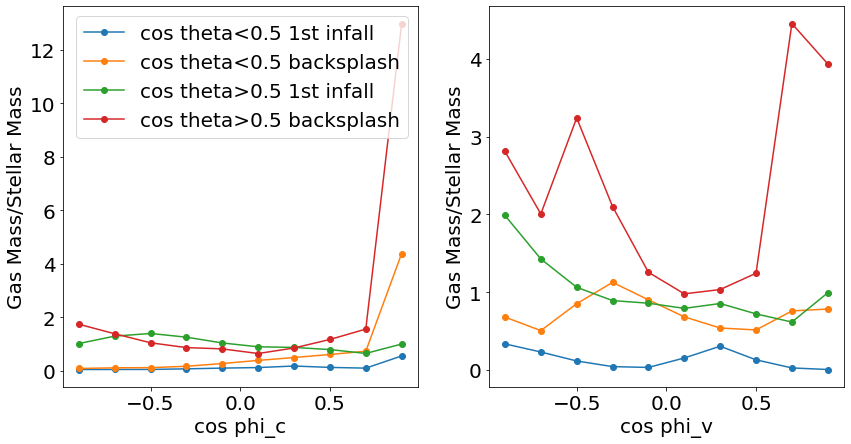

In [54]:
pl.figure(figsize=(14, 7))

sumC1_1, binsC1_1, zipC1_1 = sp.binned_statistic(CosRc_C1_1, GASMasses_C1_1/StarMass_C1_1, statistic='sum', bins=10, range=(-1.,1.))
sumC2_1, binsC2_1, zipC2_1 = sp.binned_statistic(CosRc_C2_1, GASMasses_C2_1/StarMass_C2_1, statistic='sum', bins=10, range=(-1.,1.))

sumV1_1, binsV1_1, zipV1_1 = sp.binned_statistic(CosRv_C1_1, GASMasses_C1_1/StarMass_C1_1, statistic='sum', bins=10, range=(-1.,1.))
sumV2_1, binsV2_1, zipV2_1 = sp.binned_statistic(CosRv_C2_1, GASMasses_C2_1/StarMass_C2_1, statistic='sum', bins=10, range=(-1.,1.))


sumC1_2, binsC1_2, zipC1_2 = sp.binned_statistic(CosRc_C1_2, GASMasses_C1_2/StarMass_C1_2, statistic='sum', bins=10, range=(-1.,1.))
sumC2_2, binsC2_2, zipC2_2 = sp.binned_statistic(CosRc_C2_2, GASMasses_C2_2/StarMass_C2_2, statistic='sum', bins=10, range=(-1.,1.))

sumV1_2, binsV1_2, zipV1_2 = sp.binned_statistic(CosRv_C1_2, GASMasses_C1_2/StarMass_C1_2, statistic='sum', bins=10, range=(-1.,1.))
sumV2_2, binsV2_2, zipV2_2 = sp.binned_statistic(CosRv_C2_2, GASMasses_C2_2/StarMass_C2_2, statistic='sum', bins=10, range=(-1.,1.))

# bins should be the same
x_x = .5*(binsV2_1[:-1]+binsV2_1[1:])

pl.subplot(1, 2, 1)

pl.plot(x_x, sumC1_1, marker='o', label='cos theta<0.5 1st infall')
pl.plot(x_x, sumC1_2, marker='o', label='cos theta<0.5 backsplash')
pl.plot(x_x, sumC2_1, marker='o', label='cos theta>0.5 1st infall')
pl.plot(x_x, sumC2_2, marker='o', label='cos theta>0.5 backsplash')

pl.legend(loc='best')

pl.xlabel('cos phi_c')
pl.ylabel('Gas Mass/Stellar Mass')

pl.subplot(1, 2, 2)

pl.plot(x_x, sumV1_1, marker='o', label='cos theta<0.5 1st infall')
pl.plot(x_x, sumV1_2, marker='o', label='cos theta<0.5 backsplash')
pl.plot(x_x, sumV2_1, marker='o', label='cos theta>0.5 1st infall')
pl.plot(x_x, sumV2_2, marker='o', label='cos theta>0.5 backsplash')

pl.xlabel('cos phi_v')
pl.ylabel('Gas Mass/Stellar Mass')

Text(0, 0.5, 'Gas Mass/Stellar Mass')

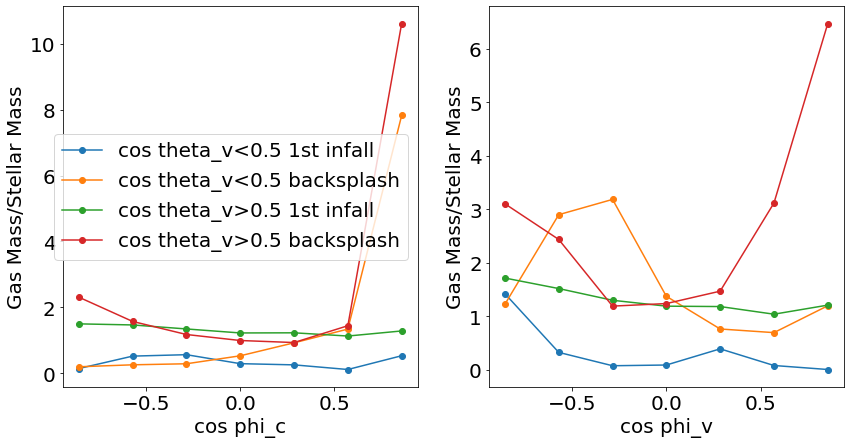

In [55]:

pl.figure(figsize=(14, 7))

sumC1_V_1, binsC1_V_1, zipC1_V_1 = sp.binned_statistic(CosRc_V1_1, GASMasses_V1_1/StarMass_V1_1, statistic='sum', bins=7, range=(-1.,1.))
sumC2_V_1, binsC2_V_1, zipC2_V_1 = sp.binned_statistic(CosRc_V2_1, GASMasses_V2_1/StarMass_V2_1, statistic='sum', bins=7, range=(-1.,1.))
sumC1_V_2, binsC1_V_2, zipC1_V_2 = sp.binned_statistic(CosRc_V1_2, GASMasses_V1_2/StarMass_V1_2, statistic='sum', bins=7, range=(-1.,1.))
sumC2_V_2, binsC2_V_2, zipC2_V_2 = sp.binned_statistic(CosRc_V2_2, GASMasses_V2_2/StarMass_V2_2, statistic='sum', bins=7, range=(-1.,1.))


sumV1_V_1, binsV1_V_1, zipV1_V_1 = sp.binned_statistic(CosRv_V1_1, GASMasses_V1_1/StarMass_V1_1, statistic='sum', bins=7, range=(-1.,1.))
sumV2_V_1, binsV2_V_1, zipV2_V_1 = sp.binned_statistic(CosRv_V2_1, GASMasses_V2_1/StarMass_V2_1, statistic='sum', bins=7, range=(-1.,1.))
sumV1_V_2, binsV1_V_2, zipV1_V_2 = sp.binned_statistic(CosRv_V1_2, GASMasses_V1_2/StarMass_V1_2, statistic='sum', bins=7, range=(-1.,1.))
sumV2_V_2, binsV2_V_2, zipV2_V_2 = sp.binned_statistic(CosRv_V2_2, GASMasses_V2_2/StarMass_V2_2, statistic='sum', bins=7, range=(-1.,1.))


# bins should be the same
x_x = .5*(binsV2_V_1[:-1]+binsV2_V_1[1:])

pl.subplot(1, 2, 1)

pl.plot(x_x, sumC1_V_1, marker='o', label='cos theta_v<0.5 1st infall')
pl.plot(x_x, sumC1_V_2, marker='o', label='cos theta_v<0.5 backsplash')
pl.plot(x_x, sumC2_V_1, marker='o', label='cos theta_v>0.5 1st infall')
pl.plot(x_x, sumC2_V_2, marker='o', label='cos theta_v>0.5 backsplash')

pl.legend(loc='best')

pl.xlabel('cos phi_c')
pl.ylabel('Gas Mass/Stellar Mass')

pl.subplot(1, 2, 2)

pl.plot(x_x, sumV1_V_1, marker='o', label='cos theta_v<0.5 1st infall')
pl.plot(x_x, sumV1_V_2, marker='o', label='cos theta_v<0.5 backsplash')

pl.plot(x_x, sumV2_V_1, marker='o', label='cos theta_v>0.5 1st infall')
pl.plot(x_x, sumV2_V_2, marker='o', label='cos theta_v>0.5 backsplash')

pl.xlabel('cos phi_v')
pl.ylabel('Gas Mass/Stellar Mass')


In [56]:
# # ok, lets see time of infall, because this is kinda weird

# def getZin(ff, cc):
#     uniqueID = int(128*1e6+ff)
#     stree = networkx.dfs_tree(trees, str(uniqueID))
#     mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
#     uniqueC = int(128*1e6+cc)
#     streeC = networkx.dfs_tree(trees, str(uniqueC))
#     mtreeC = get_main_branch_unique_ids(streeC, str(uniqueC))
    
#     z = np.inf
    
#     for mm, mC in zip(mtree, mtreeC):
#         snap, idd = split_unique_id(int(mm))
#         snapC, iddC = split_unique_id(int(mC))
#         if snap==snapC:
#             posGal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
#             posCen = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]
#             grou = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(snap)][iddC]
#             R200 = sim['SnapNumber_{}/Groups/Group_R_Crit200'.format(snap)][grou]
#             dif = posGal - posCen
#             dd = np.sqrt(np.sum(dif**2))
#             d200 = dd/R200
#             if d200<1.5: #at some point
#                 z = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]
            
#     return z

In [57]:
# zinC1 = []
# for ff, cc in zip(satC1, centC1):
#     zt = getZin(ff, cc)
#     zinC1.append(zt)
    
# zinC1 = np.array(zinC1)

# zinC2 = []
# for ff, cc in zip(satC2, centC2):
#     zt = getZin(ff, cc)
#     zinC2.append(zt)
    
# zinC2 = np.array(zinC2)

# zinV1 = []
# for ff, cc in zip(satV1, centV1):
#     zt = getZin(ff, cc)
#     zinV1.append(zt)
    
# zinV1 = np.array(zinV1)

# zinV2 = []
# for ff, cc in zip(satV2, centV2):
#     zt = getZin(ff, cc)
#     zinV2.append(zt)
    
# zinV2 = np.array(zinV2)

In [58]:
# OmegaM = sim['SnapNumber_128/Header/Omega0'][()]
# Cosmo = apc.FlatLambdaCDM(H0=100, Om0=OmegaM) 

# zinC1 = Cosmo.lookback_time(zinC1).value
# zinC2 = Cosmo.lookback_time(zinC2).value

# zinV1 = Cosmo.lookback_time(zinV1).value
# zinV2 = Cosmo.lookback_time(zinV2).value

# Z = list(zinC1)
# Z.extend(list(zinC2))
# Z.extend(list(zinV1))
# Z.extend(list(zinV2))

# zmed = np.median(Z)

# iC1_1 = np.where(zinC1<zmed)
# iC1_2 = np.where(zinC1>zmed)

# iC2_1 = np.where(zinC2<zmed)
# iC2_2 = np.where(zinC2>zmed)

# iV1_1 = np.where(zinV1<zmed)
# iV1_2 = np.where(zinV1>zmed)

# iV2_1 = np.where(zinV2<zmed)
# iV2_2 = np.where(zinV2>zmed)

# satC1_1, centC1_1 = satC1[iC1_1], centC1[iC1_1]
# satC1_2, centC1_2 = satC1[iC1_2], centC1[iC1_2]

# satC2_1, centC2_1 = satC2[iC2_1], centC2[iC2_1]
# satC2_2, centC2_2 = satC2[iC2_2], centC2[iC2_2]

# satV1_1, centV1_1 = satV1[iV1_1], centV1[iV1_1]
# satV1_2, centV1_2 = satV1[iV1_2], centV1[iV1_2]

# satV2_1, centV2_1 = satV2[iV2_1], centV2[iV2_1]
# satV2_2, centV2_2 = satV2[iV2_2], centV2[iV2_2]

# zmed

In [59]:
# # low cos central
# size = satC1_1.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_C1_1, CosRc_C1_1, GASMasses_C1_1, GASAbundances_C1_1 = [], [], [], []
# StarMass_C1_1 = []

# for ff, cc in zip(satC1_1, centC1_1):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
    
#     CosRv_C1_1.extend(list(cosRv))
#     CosRc_C1_1.extend(list(cosRc))
#     GASMasses_C1_1.extend(list(GasMasses))
#     GASAbundances_C1_1.extend(list(GasAbundances))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
    
#     StarMass_C1_1.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_C1_1, CosRc_C1_1, GASMasses_C1_1, GASAbundances_C1_1 = np.array(CosRv_C1_1), np.array(CosRc_C1_1), np.array(GASMasses_C1_1), np.array(GASAbundances_C1_1)
# StarMass_C1_1 = np.array(StarMass_C1_1)
# passs

In [60]:
# # low cos central
# size = satC1_2.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_C1_2, CosRc_C1_2, GASMasses_C1_2, GASAbundances_C1_2 = [], [], [], []
# StarMass_C1_2 = []

# for ff, cc in zip(satC1_2, centC1_2):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
    
#     CosRv_C1_2.extend(list(cosRv))
#     CosRc_C1_2.extend(list(cosRc))
#     GASMasses_C1_2.extend(list(GasMasses))
#     GASAbundances_C1_2.extend(list(GasAbundances))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
    
#     StarMass_C1_2.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_C1_2, CosRc_C1_2, GASMasses_C1_2, GASAbundances_C1_2 = np.array(CosRv_C1_2), np.array(CosRc_C1_2), np.array(GASMasses_C1_2), np.array(GASAbundances_C1_2)
# StarMass_C1_2 = np.array(StarMass_C1_2)
# passs

In [61]:
# # low cos central
# size = satC2_1.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_C2_1, CosRc_C2_1, GASMasses_C2_1, GASAbundances_C2_1 = [], [], [], []
# StarMass_C2_1 = []

# for ff, cc in zip(satC2_1, centC2_1):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
    
#     CosRv_C2_1.extend(list(cosRv))
#     CosRc_C2_1.extend(list(cosRc))
#     GASMasses_C2_1.extend(list(GasMasses))
#     GASAbundances_C2_1.extend(list(GasAbundances))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
    
#     StarMass_C2_1.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_C2_1, CosRc_C2_1, GASMasses_C2_1, GASAbundances_C2_1 = np.array(CosRv_C2_1), np.array(CosRc_C2_1), np.array(GASMasses_C2_1), np.array(GASAbundances_C2_1)
# StarMass_C2_1 = np.array(StarMass_C2_1)
# passs

In [62]:
# # low cos central
# size = satC2_2.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_C2_2, CosRc_C2_2, GASMasses_C2_2, GASAbundances_C2_2 = [], [], [], []
# StarMass_C2_2 = []

# for ff, cc in zip(satC2_2, centC2_2):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
    
#     CosRv_C2_2.extend(list(cosRv))
#     CosRc_C2_2.extend(list(cosRc))
#     GASMasses_C2_2.extend(list(GasMasses))
#     GASAbundances_C2_2.extend(list(GasAbundances))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
    
#     StarMass_C2_2.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_C2_2, CosRc_C2_2, GASMasses_C2_2, GASAbundances_C2_2 = np.array(CosRv_C2_2), np.array(CosRc_C2_2), np.array(GASMasses_C2_2), np.array(GASAbundances_C2_2)
# StarMass_C2_2 = np.array(StarMass_C2_2)
# passs

In [63]:
# # low cos central
# size = satV1_1.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_V1_1, CosRc_V1_1, GASMasses_V1_1, GASAbundances_V1_1 = [], [], [], []
# StarMass_V1_1 = []

# for ff, cc in zip(satV1_1, centV1_1):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
    
#     CosRv_V1_1.extend(list(cosRv))
#     CosRc_V1_1.extend(list(cosRc))
#     GASMasses_V1_1.extend(list(GasMasses))
#     GASAbundances_V1_1.extend(list(GasAbundances))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
    
#     StarMass_V1_1.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_V1_1, CosRc_V1_1, GASMasses_V1_1, GASAbundances_V1_1 = np.array(CosRv_V1_1), np.array(CosRc_V1_1), np.array(GASMasses_V1_1), np.array(GASAbundances_V1_1)
# StarMass_V1_1 = np.array(StarMass_V1_1)
# passs

In [64]:
# size = satV1_2.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_V1_2, CosRc_V1_2, GASMasses_V1_2, GASAbundances_V1_2 = [], [], [], []
# StarMass_V1_2 = []

# for ff, cc in zip(satV1_2, centV1_2):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
    
#     CosRv_V1_2.extend(list(cosRv))
#     CosRc_V1_2.extend(list(cosRc))
#     GASMasses_V1_2.extend(list(GasMasses))
#     GASAbundances_V1_2.extend(list(GasAbundances))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
    
#     StarMass_V1_2.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_V1_2, CosRc_V1_2, GASMasses_V1_2, GASAbundances_V1_2 = np.array(CosRv_V1_2), np.array(CosRc_V1_2), np.array(GASMasses_V1_2), np.array(GASAbundances_V1_2)
# StarMass_V1_2 = np.array(StarMass_V1_2)
# passs

In [65]:
# size = satV2_1.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_V2_1, CosRc_V2_1, GASMasses_V2_1, GASAbundances_V2_1 = [], [], [], []
# StarMass_V2_1 = []

# for ff, cc in zip(satV2_1, centV2_1):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
    
#     CosRv_V2_1.extend(list(cosRv))
#     CosRc_V2_1.extend(list(cosRc))
#     GASMasses_V2_1.extend(list(GasMasses))
#     GASAbundances_V2_1.extend(list(GasAbundances))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
    
#     StarMass_V2_1.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_V2_1, CosRc_V2_1, GASMasses_V2_1, GASAbundances_V2_1 = np.array(CosRv_V2_1), np.array(CosRc_V2_1), np.array(GASMasses_V2_1), np.array(GASAbundances_V2_1)
# StarMass_V2_1 = np.array(StarMass_V2_1)
# passs

In [66]:
# size = satV2_2.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_V2_2, CosRc_V2_2, GASMasses_V2_2, GASAbundances_V2_2 = [], [], [], []
# StarMass_V2_2 = []

# for ff, cc in zip(satV2_2, centV2_2):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
    
#     CosRv_V2_2.extend(list(cosRv))
#     CosRc_V2_2.extend(list(cosRc))
#     GASMasses_V2_2.extend(list(GasMasses))
#     GASAbundances_V2_2.extend(list(GasAbundances))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
    
#     StarMass_V2_2.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_V2_2, CosRc_V2_2, GASMasses_V2_2, GASAbundances_V2_2 = np.array(CosRv_V2_2), np.array(CosRc_V2_2), np.array(GASMasses_V2_2), np.array(GASAbundances_V2_2)
# StarMass_V2_2 = np.array(StarMass_V2_2)
# passs

In [67]:
# zmedi = np.int(zmed*100.)/100.

# pl.figure(figsize=(14, 7))

# sumC1_1, binsC1_1, zipC1_1 = sp.binned_statistic(CosRc_C1_1, GASMasses_C1_1/StarMass_C1_1, statistic='sum', bins=10, range=(-1.,1.))
# sumC2_1, binsC2_1, zipC2_1 = sp.binned_statistic(CosRc_C2_1, GASMasses_C2_1/StarMass_C2_1, statistic='sum', bins=10, range=(-1.,1.))

# sumV1_1, binsV1_1, zipV1_1 = sp.binned_statistic(CosRv_C1_1, GASMasses_C1_1/StarMass_C1_1, statistic='sum', bins=10, range=(-1.,1.))
# sumV2_1, binsV2_1, zipV2_1 = sp.binned_statistic(CosRv_C2_1, GASMasses_C2_1/StarMass_C2_1, statistic='sum', bins=10, range=(-1.,1.))


# sumC1_2, binsC1_2, zipC1_2 = sp.binned_statistic(CosRc_C1_2, GASMasses_C1_2/StarMass_C1_2, statistic='sum', bins=10, range=(-1.,1.))
# sumC2_2, binsC2_2, zipC2_2 = sp.binned_statistic(CosRc_C2_2, GASMasses_C2_2/StarMass_C2_2, statistic='sum', bins=10, range=(-1.,1.))

# sumV1_2, binsV1_2, zipV1_2 = sp.binned_statistic(CosRv_C1_2, GASMasses_C1_2/StarMass_C1_2, statistic='sum', bins=10, range=(-1.,1.))
# sumV2_2, binsV2_2, zipV2_2 = sp.binned_statistic(CosRv_C2_2, GASMasses_C2_2/StarMass_C2_2, statistic='sum', bins=10, range=(-1.,1.))

# # bins should be the same
# x_x = .5*(binsV2_1[:-1]+binsV2_1[1:])

# pl.subplot(1, 2, 1)

# pl.plot(x_x, sumC1_1, marker='o', label='cos theta<0.5 t_in<{} Gyrs'.format(zmedi))
# pl.plot(x_x, sumC1_2, marker='o', label='cos theta<0.5 t_in>{} Gyrs'.format(zmedi))
# pl.plot(x_x, sumC2_1, marker='o', label='cos theta>0.5 t_in<{} Gyrs'.format(zmedi))
# pl.plot(x_x, sumC2_2, marker='o', label='cos theta>0.5 t_in>{} Gyrs'.format(zmedi))

# pl.legend(loc='best')

# pl.xlabel('cos phi_c')
# pl.ylabel('Gas Mass/Stellar Mass')

# pl.subplot(1, 2, 2)

# pl.plot(x_x, sumV1_1, marker='o', label='cos theta<0.5 t_in<{} Gyrs'.format(zmedi))
# pl.plot(x_x, sumV1_2, marker='o', label='cos theta<0.5 t_in>{} Gyrs'.format(zmedi))
# pl.plot(x_x, sumV2_1, marker='o', label='cos theta>0.5 t_in<{} Gyrs'.format(zmedi))
# pl.plot(x_x, sumV2_2, marker='o', label='cos theta>0.5 t_in>{} Gyrs'.format(zmedi))

# pl.xlabel('cos phi_v')
# pl.ylabel('Gas Mass/Stellar Mass')

In [68]:

# pl.figure(figsize=(14, 7))

# sumC1_V_1, binsC1_V_1, zipC1_V_1 = sp.binned_statistic(CosRc_V1_1, GASMasses_V1_1/StarMass_V1_1, statistic='sum', bins=7, range=(-1.,1.))
# sumC2_V_1, binsC2_V_1, zipC2_V_1 = sp.binned_statistic(CosRc_V2_1, GASMasses_V2_1/StarMass_V2_1, statistic='sum', bins=7, range=(-1.,1.))
# sumC1_V_2, binsC1_V_2, zipC1_V_2 = sp.binned_statistic(CosRc_V1_2, GASMasses_V1_2/StarMass_V1_2, statistic='sum', bins=7, range=(-1.,1.))
# sumC2_V_2, binsC2_V_2, zipC2_V_2 = sp.binned_statistic(CosRc_V2_2, GASMasses_V2_2/StarMass_V2_2, statistic='sum', bins=7, range=(-1.,1.))


# sumV1_V_1, binsV1_V_1, zipV1_V_1 = sp.binned_statistic(CosRv_V1_1, GASMasses_V1_1/StarMass_V1_1, statistic='sum', bins=7, range=(-1.,1.))
# sumV2_V_1, binsV2_V_1, zipV2_V_1 = sp.binned_statistic(CosRv_V2_1, GASMasses_V2_1/StarMass_V2_1, statistic='sum', bins=7, range=(-1.,1.))
# sumV1_V_2, binsV1_V_2, zipV1_V_2 = sp.binned_statistic(CosRv_V1_2, GASMasses_V1_2/StarMass_V1_2, statistic='sum', bins=7, range=(-1.,1.))
# sumV2_V_2, binsV2_V_2, zipV2_V_2 = sp.binned_statistic(CosRv_V2_2, GASMasses_V2_2/StarMass_V2_2, statistic='sum', bins=7, range=(-1.,1.))


# # bins should be the same
# x_x = .5*(binsV2_V_1[:-1]+binsV2_V_1[1:])

# pl.subplot(1, 2, 1)

# pl.plot(x_x, sumC1_V_1, marker='o', label='cos theta_v<0.5 t_in<{} Gyrs'.format(zmedi))
# pl.plot(x_x, sumC1_V_2, marker='o', label='cos theta_v<0.5 t_in>{} Gyrs'.format(zmedi))
# pl.plot(x_x, sumC2_V_1, marker='o', label='cos theta_v>0.5 t_in<{} Gyrs'.format(zmedi))
# pl.plot(x_x, sumC2_V_2, marker='o', label='cos theta_v>0.5 t_in>{} Gyrs'.format(zmedi))

# pl.legend(loc='best')

# pl.xlabel('cos phi_c')
# pl.ylabel('Gas Mass/Stellar Mass')

# pl.subplot(1, 2, 2)

# pl.plot(x_x, sumV1_V_1, marker='o', label='cos theta_v<0.5 t_in<{} Gyrs'.format(zmedi))
# pl.plot(x_x, sumV1_V_2, marker='o', label='cos theta_v<0.5 t_in>{} Gyrs'.format(zmedi))

# pl.plot(x_x, sumV2_V_1, marker='o', label='cos theta_v>0.5 t_in<{} Gyrs'.format(zmedi))
# pl.plot(x_x, sumV2_V_2, marker='o', label='cos theta_v>0.5 t_in>{} Gyrs'.format(zmedi))

# pl.xlabel('cos phi_v')
# pl.ylabel('Gas Mass/Stellar Mass')
